In [2]:
import numpy as np
import pickle

In [111]:
with open("../data/2023-06-07T14:37:.711786/run_data_49000.pkl", "rb") as f:
    smart_run_data = pickle.load(f)
  
with open("../data/2023-06-07T22:35:.884914_baseline/run_data_80000.pkl", "rb") as f:
    baseline_run_data = pickle.load(f)

smart_episode_rewards = smart_run_data["episode_rewards"]
smart_execution_coverage = smart_run_data["execution_coverage"]
smart_final_coverage = smart_run_data["current_coverage"]
smart_total_steps = smart_run_data["total_steps"]
smart_total_executions = smart_run_data["total_executions"]

baseline_episode_rewards = baseline_run_data["episode_rewards"]
baseline_execution_coverage = baseline_run_data["execution_coverage"]
baseline_final_coverage = baseline_run_data["current_coverage"]
baseline_total_steps = baseline_run_data["total_steps"]
baseline_total_executions = baseline_run_data["total_executions"]

In [112]:
baseline_episode_rewards_summed = [sum(x) for x in baseline_episode_rewards]
smart_episode_rewards_summed = [sum(x) for x in smart_episode_rewards]

baseline_episode_len = [len(x) for x in baseline_episode_rewards]
smart_episode_len = [len(x) for x in smart_episode_rewards]

print(f"Average episode reward: {np.mean(smart_episode_rewards_summed)}, {np.mean(baseline_episode_rewards_summed)}")
print(f"Average episode length: {np.mean(smart_episode_len)}, {np.mean(baseline_episode_len)}")

print(f"Final coverage: smart: {smart_final_coverage:.5%}, baseline: {baseline_final_coverage:.5%}")
print(f"Total steps: smart: {smart_total_steps}, baseline: {baseline_total_steps}")
print(f"Total executions: smart: {smart_total_executions}, baseline: {baseline_total_executions}")
print(f"Number of episodes: smart: {len(smart_episode_rewards)}, baseline: {len(baseline_episode_rewards)}")


Average episode reward: 4.14207766311074, -4.2464277133289166
Average episode length: 57.389214536928485, 7.037828802674408
Final coverage: smart: 20.91143%, baseline: 20.97692%
Total steps: smart: 49000, baseline: 80000
Total executions: smart: 17085, baseline: 18854
Number of episodes: smart: 853, baseline: 11367


Text(0.5, 1.0, 'Coverage vs. Number of Actions')

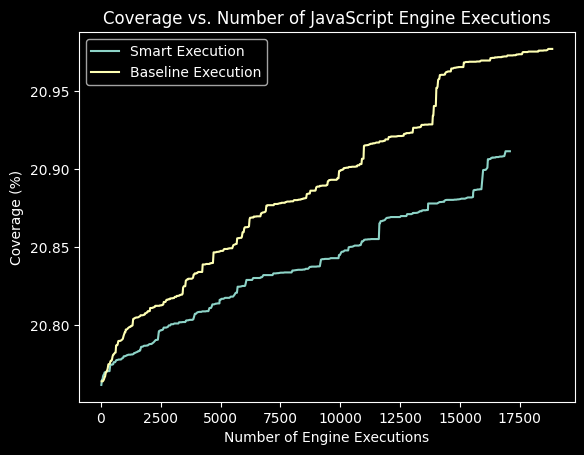

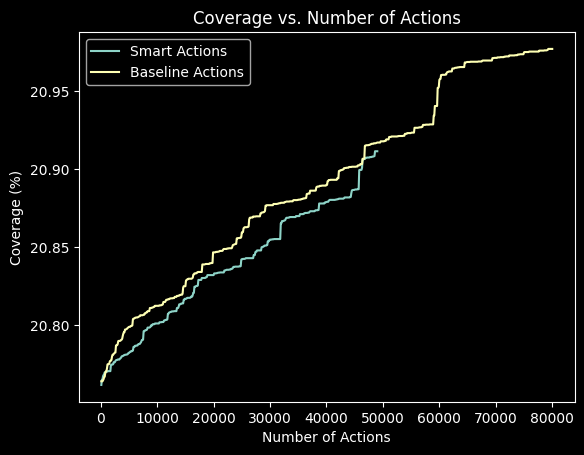

In [113]:
smart_x_exec = []
smart_x_action = []
smart_y = []

baseline_x_exec = []
baseline_x_action = []
baseline_y = []

for (execution, num_actions), coverage in smart_execution_coverage.items():
    smart_x_exec.append(execution)
    smart_x_action.append(num_actions)
    smart_y.append(coverage*100)

for (execution, num_actions), coverage in baseline_execution_coverage.items():
    baseline_x_exec.append(execution)
    baseline_x_action.append(num_actions)
    baseline_y.append(coverage*100)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.lineplot(x=smart_x_exec, y=smart_y, label="Smart Execution")
sns.lineplot(x=baseline_x_exec, y=baseline_y, label="Baseline Execution")
plt.xlabel("Number of Engine Executions")
plt.ylabel("Coverage (%)")
plt.title("Coverage vs. Number of JavaScript Engine Executions")

plt.figure()
sns.lineplot(x=smart_x_action, y=smart_y, label="Smart Actions")
sns.lineplot(x=baseline_x_action, y=baseline_y, label="Baseline Actions")
plt.xlabel("Number of Actions")
plt.ylabel("Coverage (%)")
plt.title("Coverage vs. Number of Actions")


Text(0.5, 1.0, 'Episode Rewards')

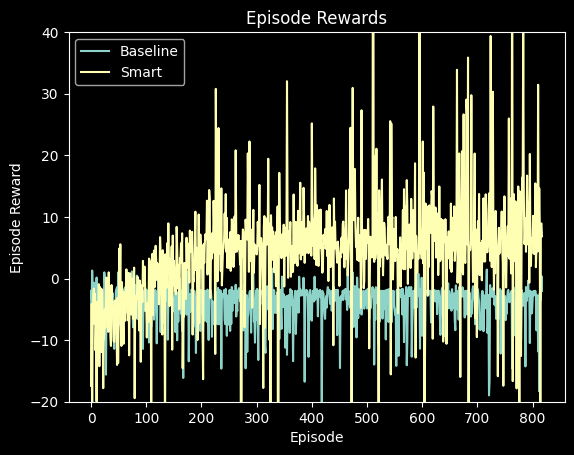

In [107]:
episodes = min(len(smart_episode_rewards), len(baseline_episode_rewards))

plt.figure()
sns.lineplot(x = np.arange(episodes),y=baseline_episode_rewards_summed[:episodes], label="Baseline")
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.ylim(-20, 40)


# plt.figure()
sns.lineplot(x = np.arange(episodes),y=smart_episode_rewards_summed[:episodes], label="Smart")
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.ylim(-20, 40)

plt.title("Episode Rewards")


